In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input, Reshape
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, num_layers=1, units=32, activation='relu'):
        super(CustomLayer, self).__init__()
        self.num_layers = num_layers
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.dense_layers = []

    def build(self, input_shape):
        for i in range(self.num_layers):
            self.dense_layers.append(
                tf.keras.layers.Dense(
                    self.units,
                    activation=self.activation,
                    kernel_initializer='he_normal'
                )
            )

    def call(self, inputs):
        x = inputs
        for dense in self.dense_layers:
            x = dense(x)
        return x


In [15]:
class GRUCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GRUCell, self).__init__()
        self.units = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Weights for update gate z
        self.W_z = self.add_weight(shape=(input_dim, self.units), initializer="glorot_uniform", name="W_z")
        self.U_z = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_z")
        self.b_z = self.add_weight(shape=(self.units,), initializer="zeros", name="b_z")

        # Weights for reset gate r
        self.W_r = self.add_weight(shape=(input_dim, self.units), initializer="glorot_uniform", name="W_r")
        self.U_r = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_r")
        self.b_r = self.add_weight(shape=(self.units,), initializer="zeros", name="b_r")

        # Weights for candidate hidden state h̃
        self.W_h = self.add_weight(shape=(input_dim, self.units), initializer="glorot_uniform", name="W_h")
        self.U_h = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_h")
        self.b_h = self.add_weight(shape=(self.units,), initializer="zeros", name="b_h")

    def call(self, x_t, h_prev):
        z = tf.sigmoid(tf.matmul(x_t, self.W_z) + tf.matmul(h_prev, self.U_z) + self.b_z)
        r = tf.sigmoid(tf.matmul(x_t, self.W_r) + tf.matmul(h_prev, self.U_r) + self.b_r)
        h_candidate = tf.tanh(tf.matmul(x_t, self.W_h) + tf.matmul(r * h_prev, self.U_h) + self.b_h)
        h_t = (1 - z) * h_prev + z * h_candidate
        return h_t

class CustomGRULayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomGRULayer, self).__init__()
        self.units = units
        self.cell = GRUCell(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        h = tf.zeros((batch_size, self.units))
        outputs = []

        for t in range(inputs.shape[1]):
            x_t = inputs[:, t, :]
            h = self.cell(x_t, h)
            outputs.append(h)

        return tf.stack(outputs, axis=1)  # (batch, time, units)




In [18]:
# Load and preprocess the dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define the model
model = Sequential([
    Input(shape=(X.shape[1],)),
    CustomLayer(num_layers=3, units=64, activation='relu'),
    Reshape((8, 8)),
    CustomGRULayer(units=32),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model and save training history
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6563 - loss: 0.6112 - val_accuracy: 0.8947 - val_loss: 0.4308
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9052 - loss: 0.3933 - val_accuracy: 0.9649 - val_loss: 0.2038
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9601 - loss: 0.1979 - val_accuracy: 0.9912 - val_loss: 0.0989
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9681 - loss: 0.1142 - val_accuracy: 0.9912 - val_loss: 0.0700
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9787 - loss: 0.0808 - val_accuracy: 0.9912 - val_loss: 0.0658
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9839 - loss: 0.0680 - val_accuracy: 0.9912 - val_loss: 0.0639
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9880 - loss: 0.0541 - val_accuracy: 0.9825 - val_loss: 0.0650
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9876 - loss: 0.0546 - val_accuracy: 0.9825 - v

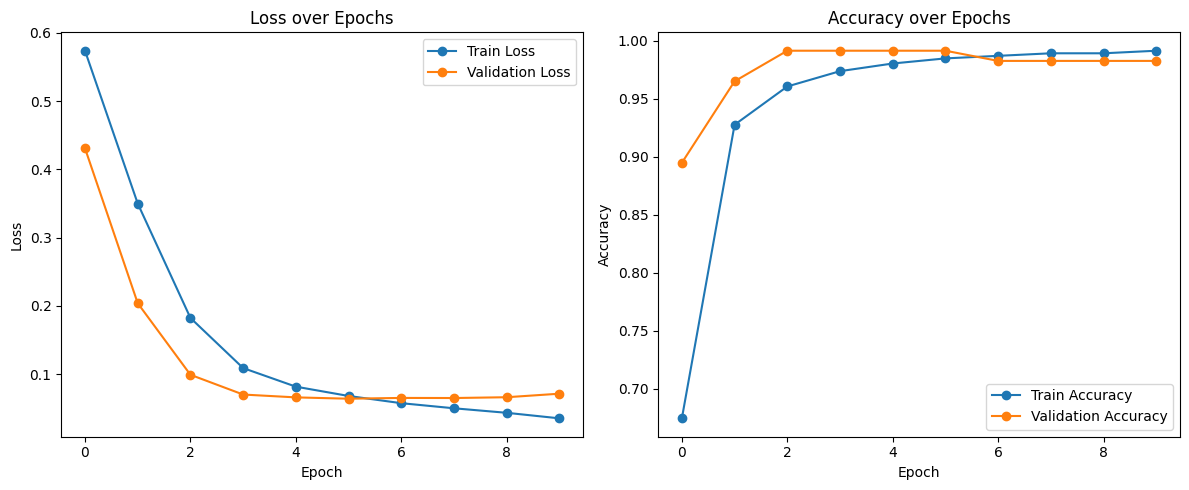

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


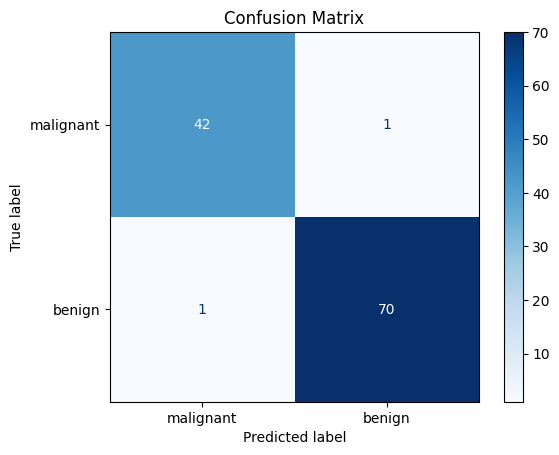

In [19]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on test set and plot confusion matrix
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()